This is the code used by Group 8 to analyze the results of our WRF simulations and compare them to observed data. This was performed on a personal computer, and the file was uploaded here later with the output. Please note that the packages needed required a specific environment setup to run, something which may not be repeatable on google colab.

In [ ]:
!python --version

Python 3.6.13 :: Anaconda, Inc.


In [ ]:
#imports
import xarray as xr
from glob import glob
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import wrf
import matplotlib.pyplot as plt
import re
from wrf import getvar, interplevel, latlon_coords, ll_to_xy, ALL_TIMES

from tqdm import tqdm
tqdm.pandas()

In [ ]:
#functions
def get_nearest_wrf_time_index(obs_time):
    time_diffs = abs(wrf_times - pd.to_datetime(obs_time))
    return time_diffs.argmin()

def get_wrf_wind_at_time_and_location(lat, lon, time):
    x, y = ll_to_xy(wrf_datasets, lat, lon)
    x, y = int(x), int(y)
    time_idx = get_nearest_wrf_time_index(time)
    val = wspd10.isel(Time=time_idx, bottom_top=0, south_north=y, west_east=x)
    return float(val)

def parse_time_to_seconds(time_str):
    match = re.match(r'(?:(\d+)m)?(\d+\.\d+)s', time_str)
    if match:
        minutes = int(match.group(1)) if match.group(1) else 0
        seconds = float(match.group(2))
        return minutes * 60 + seconds
    return None  # or raise an error if needed

## Load in observed data (NCEI)

In [ ]:
obs_df = pd.read_csv("ISDNOAA041925NYC.csv")
obs_df['DATE'] = pd.to_datetime(obs_df['DATE'])
wnd_split = obs_df['WND'].str.split(',', expand=True)
valid_mask = wnd_split[4] != '9'
obs_df = obs_df[valid_mask].copy()
wnd_split = obs_df['WND'].str.split(',', expand=True)
obs_df['WND_SPEED'] = pd.to_numeric(wnd_split[3], errors='coerce') / 10.0

## Load in WRF predictions, Compare Observed and Actual

### Single instance

100%|█████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 148.60it/s]


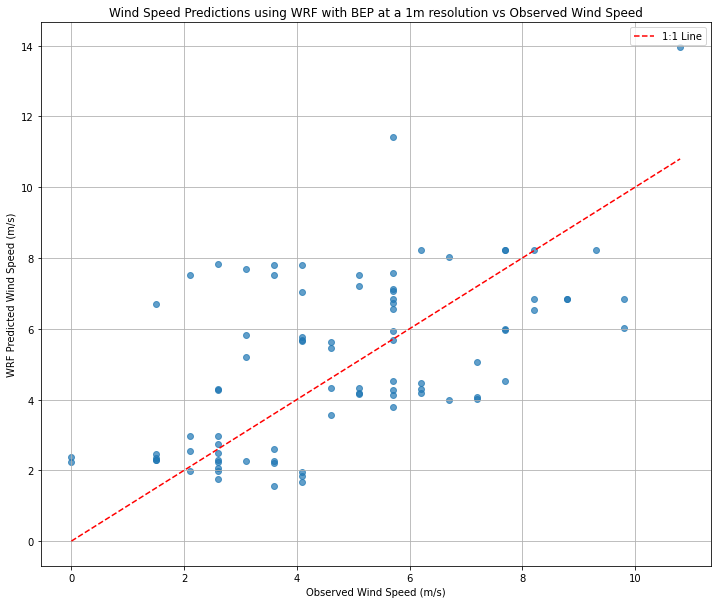

MAE:  1.77 m/s
RMSE: 2.19 m/s


In [ ]:
resolution = "1m"#["1m","2m","5m"]
usf = 2#[0,1,2,3]
usf_dict = {0:"WRF (Control)",1:"WRF with SLUCM", 2:"WRF with BEP", 3: "WRF with BEP + BEM"}


#load in wrf files
wrf_files = sorted(glob(f'{resolution}_uf{usf}/wrfout*'))

wrf_datasets = [Dataset(f) for f in wrf_files]

wspd10 = getvar(wrf_datasets, "wspd", timeidx=ALL_TIMES, units="m/s")

# Extract time dimension
wrf_times = getvar(wrf_datasets, "times", timeidx=ALL_TIMES).to_index()
obs_df['WRF_WIND'] = obs_df.progress_apply(lambda row: get_wrf_wind_at_time_and_location(
    row['LATITUDE'], row['LONGITUDE'], row['DATE']), axis=1)

plt.figure(figsize=(12,10))
plt.scatter(obs_df['WND_SPEED'], obs_df['WRF_WIND'], alpha=0.7)
plt.plot([obs_df['WND_SPEED'].min(), obs_df['WND_SPEED'].max()],
         [obs_df['WND_SPEED'].min(), obs_df['WND_SPEED'].max()],
         'r--', label='1:1 Line')
plt.xlabel('Observed Wind Speed (m/s)')
plt.ylabel('WRF Predicted Wind Speed (m/s)')
plt.title(f'Wind Speed Predictions using {usf_dict[usf]} at a {resolution} resolution vs Observed Wind Speed')
plt.legend()
plt.grid(True)
plt.show()

#Convert columns to NumPy arrays
y_true = obs_df['WND_SPEED'].to_numpy()
y_pred = obs_df['WRF_WIND'].to_numpy()

#Remove any NaNs to avoid errors
mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
y_true = y_true[mask]
y_pred = y_pred[mask]

#Mean Absolute Error
mae = np.mean(np.abs(y_true - y_pred))

#Root Mean Squared Error
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

# Output
print(f"MAE:  {mae:.2f} m/s")
print(f"RMSE: {rmse:.2f} m/s")


### All instances, save output graphs

completed 1m resolution
completed 2m resolution
completed 5m resolution


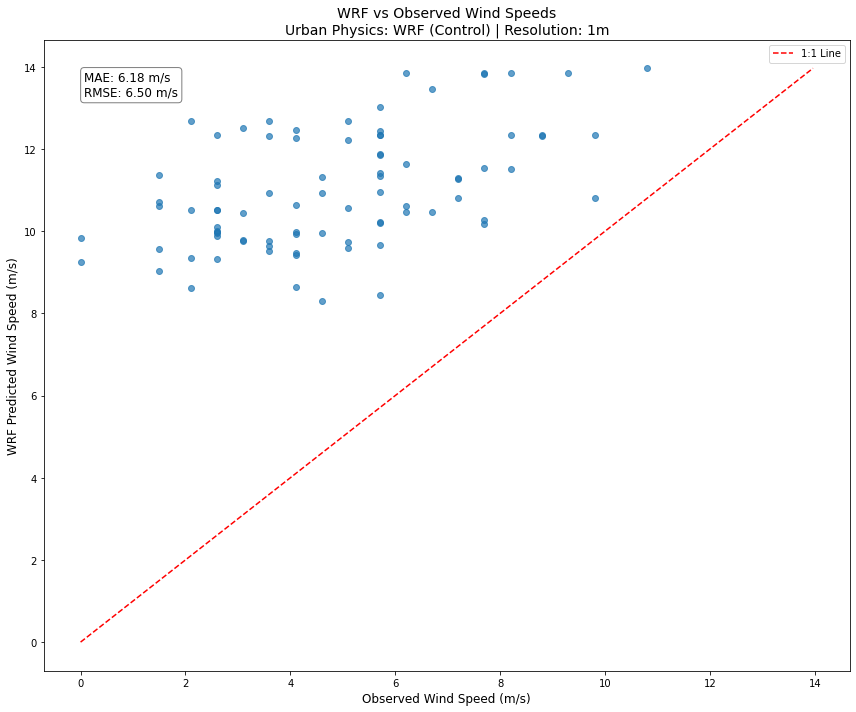

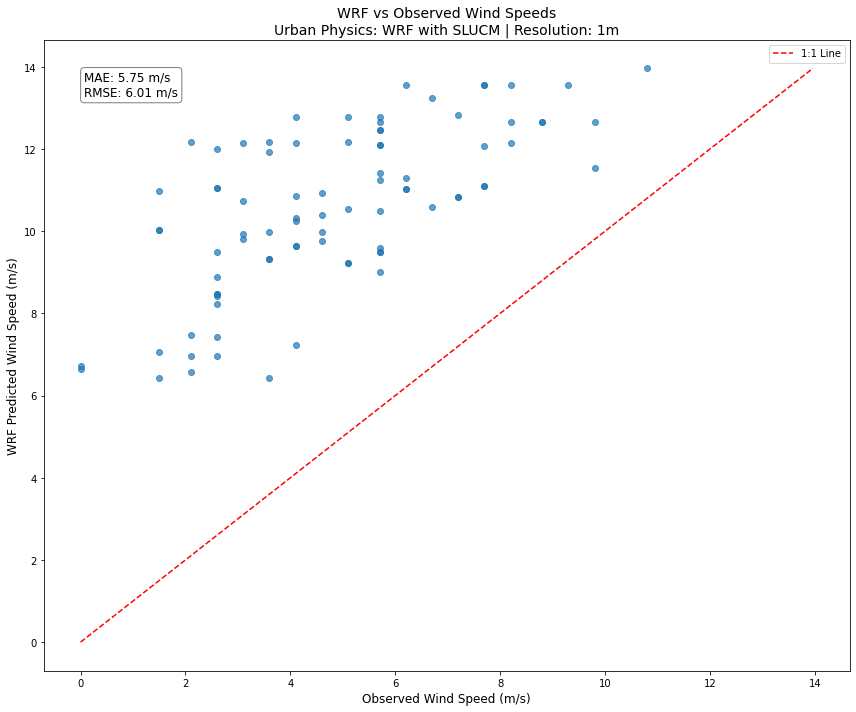

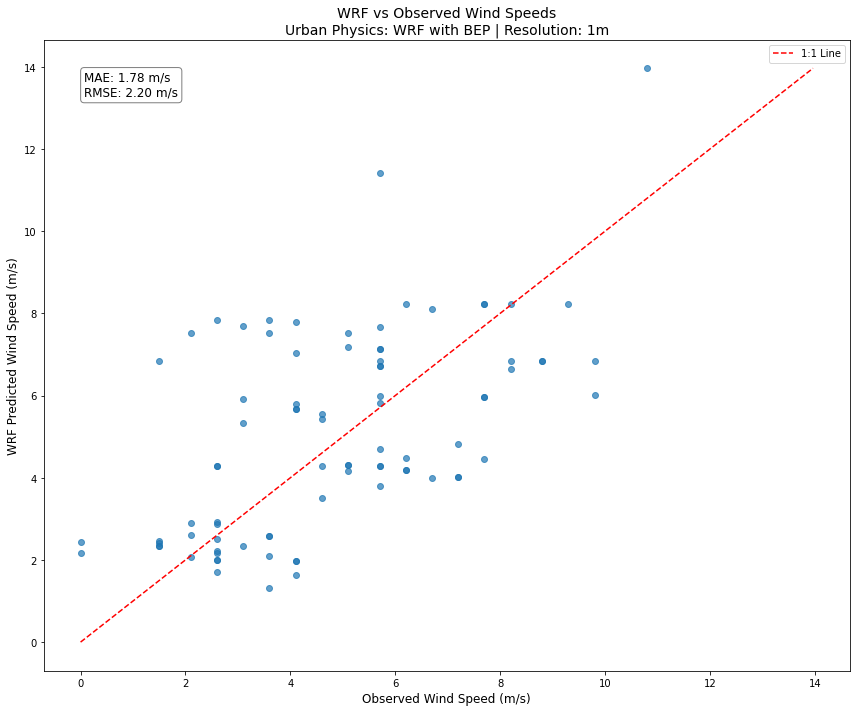

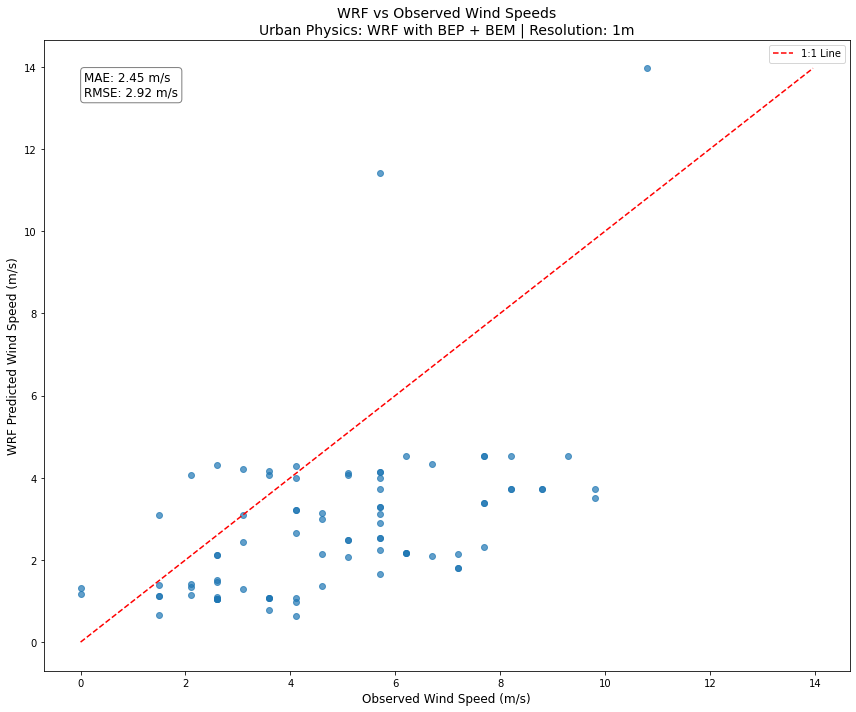

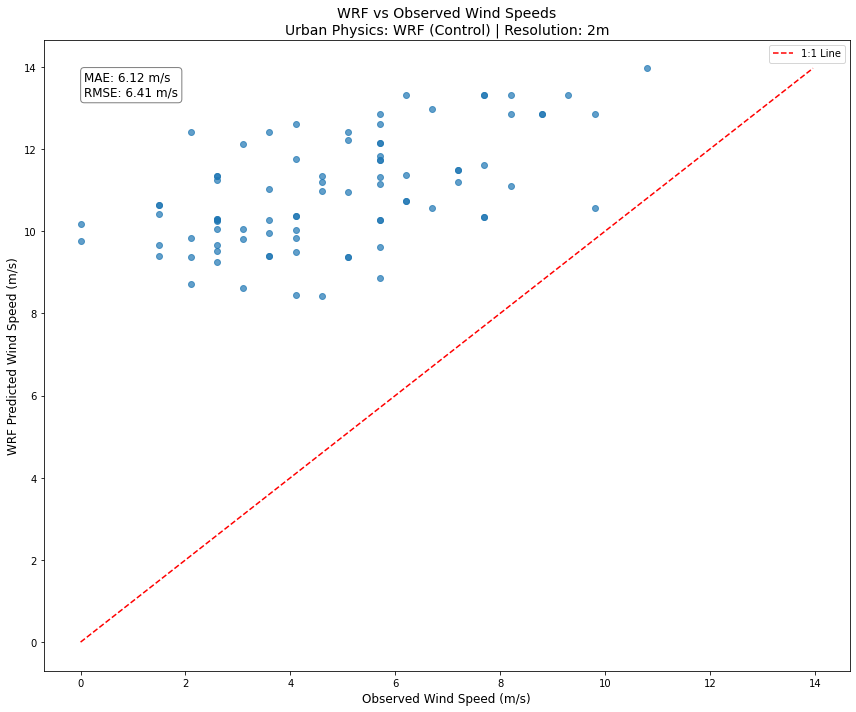

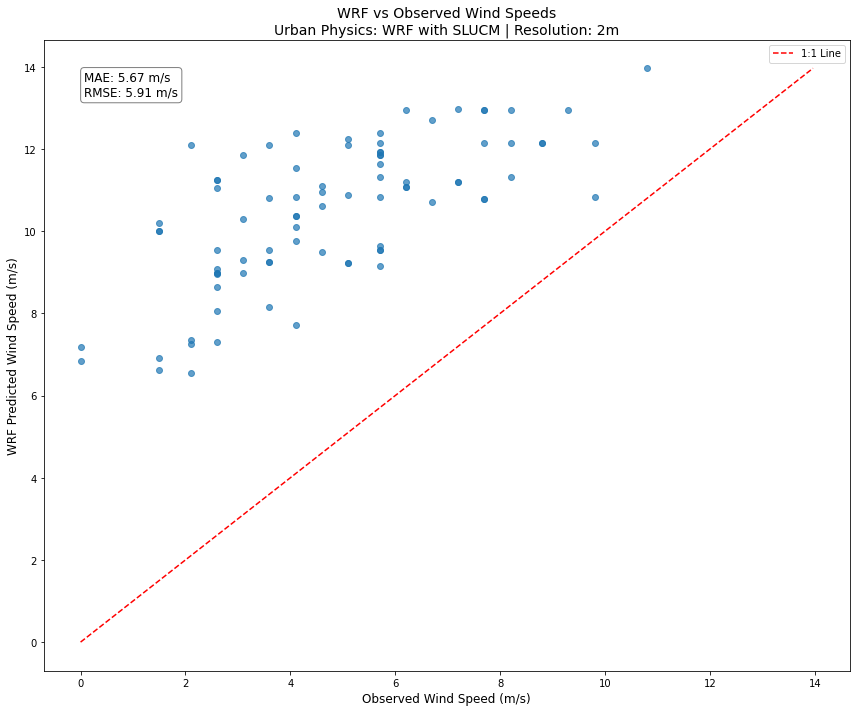

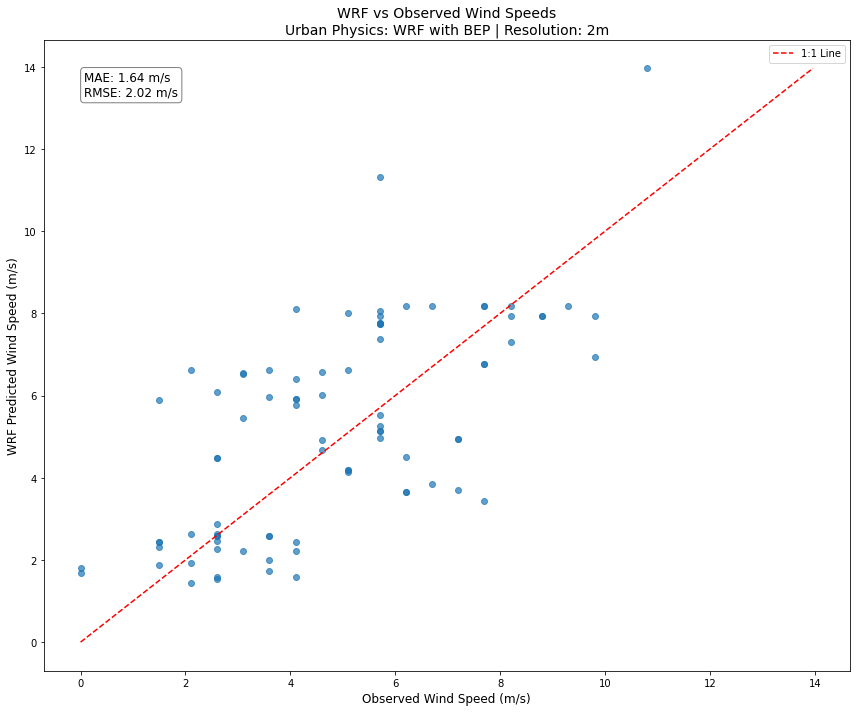

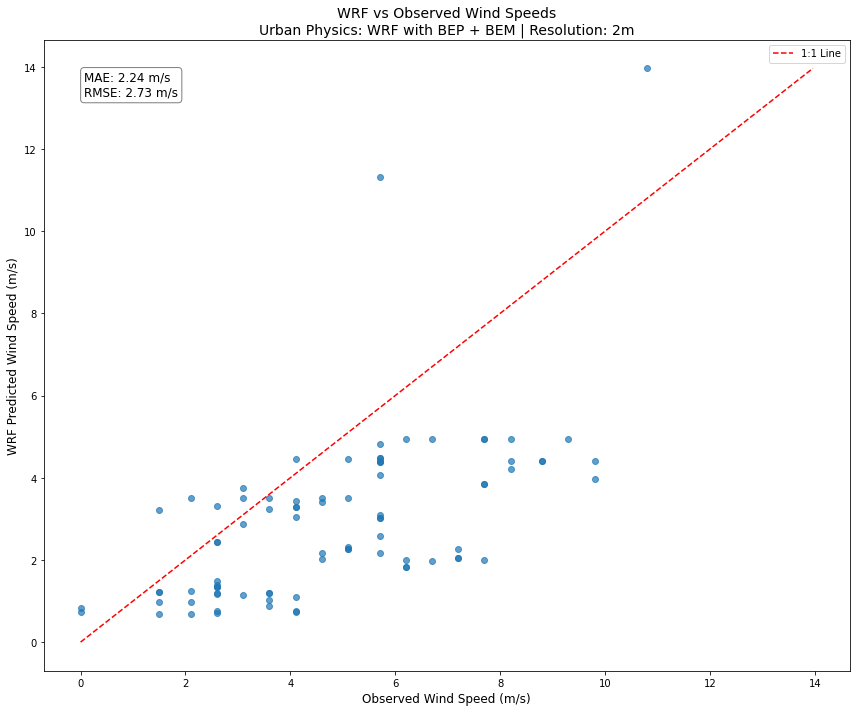

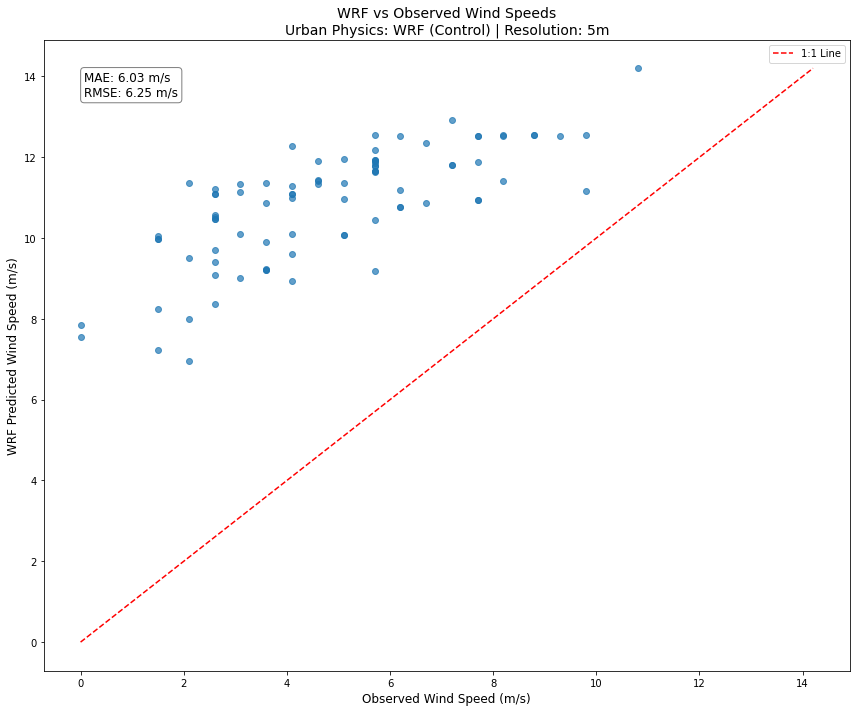

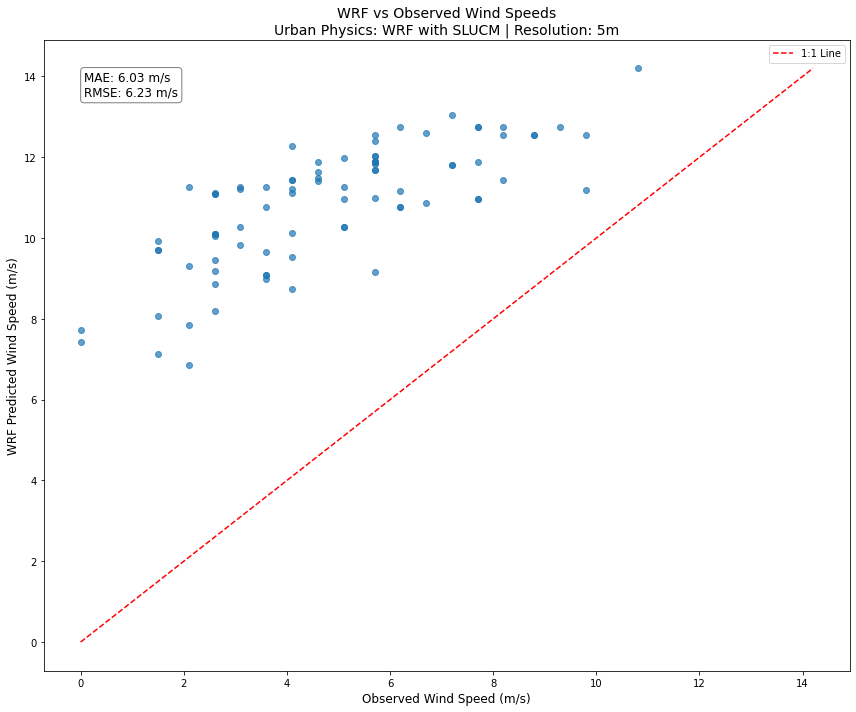

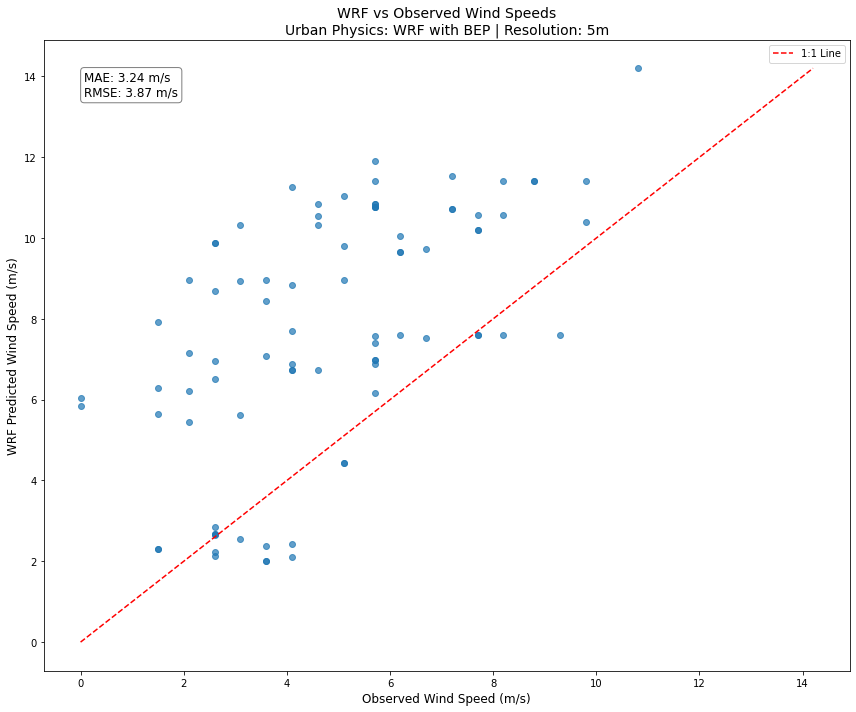

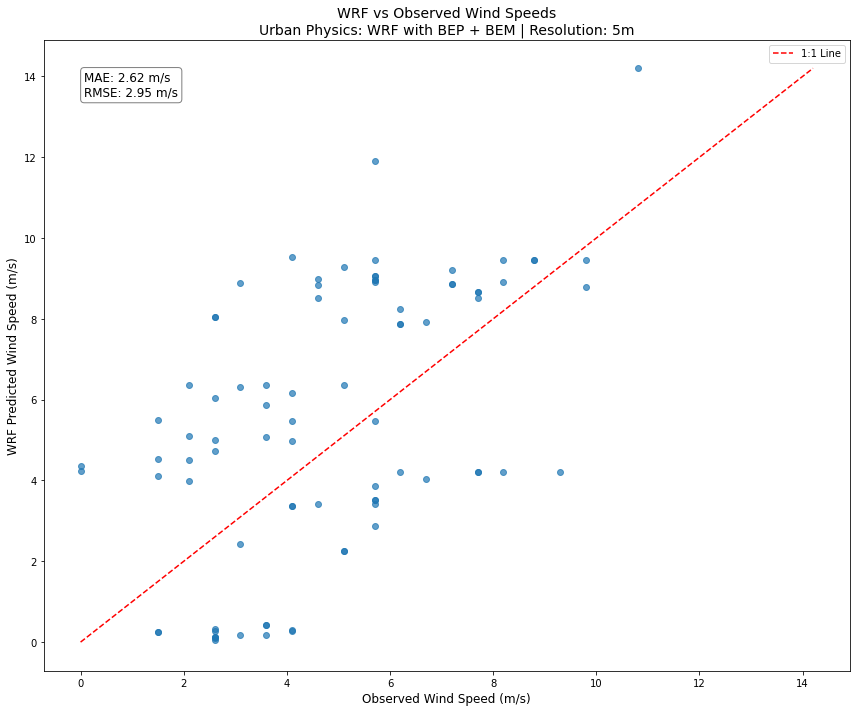

In [ ]:
res_list = ["1m","2m","5m"]
usf_list = [0,1,2,3]
usf_dict = {0:"WRF (Control)",1:"WRF with SLUCM", 2:"WRF with BEP", 3: "WRF with BEP + BEM"}


rmse_df = pd.DataFrame()
mae_df = pd.DataFrame()
for resolution in res_list:
    rmse_list = []
    mae_list = []
    for usf in usf_list:
        #load in wrf files
        wrf_files = sorted(glob(f'{resolution}_uf{usf}/wrfout*'))
        wrf_datasets = [Dataset(f) for f in wrf_files]
        wspd10 = getvar(wrf_datasets, "wspd", timeidx=ALL_TIMES, units="m/s")
        wrf_times = getvar(wrf_datasets, "times", timeidx=ALL_TIMES).to_index()

        #compare predicted to observed
        obs_df['WRF_WIND'] = obs_df.apply(lambda row: get_wrf_wind_at_time_and_location(
            row['LATITUDE'], row['LONGITUDE'], row['DATE']), axis=1)


        #calculate MAE and RMSE
        mae = np.mean(np.abs(obs_df['WND_SPEED'] - obs_df['WRF_WIND']))
        mae_list.append(mae)
        rmse = np.sqrt(np.mean((obs_df['WND_SPEED'] - obs_df['WRF_WIND'])**2))
        rmse_list.append(rmse)

        #create the plot
        plt.figure(figsize=(12, 10))
        plt.scatter(obs_df['WND_SPEED'], obs_df['WRF_WIND'], alpha=0.7)

        #plot 1:1 line
        min_val = min(obs_df['WND_SPEED'].min(), obs_df['WRF_WIND'].min())
        max_val = max(obs_df['WND_SPEED'].max(), obs_df['WRF_WIND'].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')

        #labels and title
        plt.xlabel('Observed Wind Speed (m/s)', fontsize=12)
        plt.ylabel('WRF Predicted Wind Speed (m/s)', fontsize=12)
        plt.title(f'WRF vs Observed Wind Speeds\nUrban Physics: {usf_dict[usf]} | Resolution: {resolution}', fontsize=14)

        #metrics overlay
        plt.text(0.05, 0.95, f'MAE: {mae:.2f} m/s\nRMSE: {rmse:.2f} m/s',
                 transform=plt.gca().transAxes,
                 fontsize=12,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        plt.legend()
        plt.tight_layout()

        plt.savefig(f'{resolution}_{usf_dict[usf]}', dpi=300)

        plt.show()
    rmse_df[f'{resolution} res'] = rmse_list
    mae_df[f'{resolution} res'] = mae_list
    print(f'completed {resolution} resolution')

### Results

In [ ]:
mae_df

,1m res,2m res,5m res
0,6.181327,6.120075,6.034139
1,5.750891,5.670599,6.029724
2,1.779705,1.639374,3.237920
3,2.446976,2.237299,2.619305


In [ ]:
rmse_df

,1m res,2m res,5m res
0,6.503668,6.412931,6.245120
1,6.011242,5.913179,6.228254
2,2.200323,2.022641,3.867266
3,2.924298,2.725469,2.948221


## Compare Runtimes

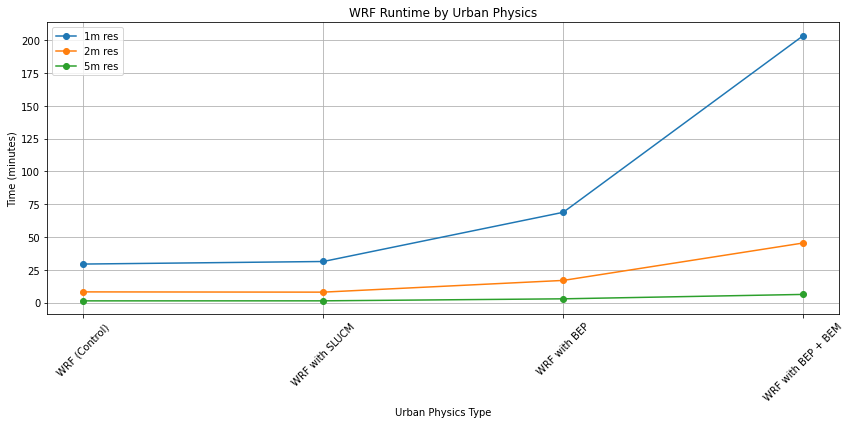

In [ ]:
runtime_df = pd.read_csv("Runtimes.csv")
runtime_df.head()

runtime_df = runtime_df.applymap(parse_time_to_seconds)

runtime_df = runtime_df / 60

runtime_df['Category'] = runtime_df.index.map(usf_dict)

#plot
plt.figure(figsize=(12, 6))

for column in runtime_df.columns[:-1]:
    plt.plot(runtime_df['Category'], runtime_df[column], marker='o', label=column)

plt.xlabel("Urban Physics Type")
plt.ylabel("Time (minutes)")
#plt.yscale('log')
plt.title("WRF Runtime by Urban Physics")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()